In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
# Librerías comunes (ejecuta una vez)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import coint
from scipy.stats import zscore
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,5)


Recopilación de los datos de BBVA y Banco Santander de yahoo finances. ddesde el 1 de enero de 2000 hasta la fecha

In [60]:
import yfinance as yf
import pandas as pd
BBVA_ticker = "BBVA.MC" 
SANTANDER_ticker = "SAN.MC"

start_date = "2000-01-01"
end_date = None  # hasta hoy

# Descargar datos históricos
BBVA_data = yf.download(BBVA_ticker, start=start_date, end=end_date, auto_adjust=True, actions=True)
SANTANDER_data = yf.download(SANTANDER_ticker, start=start_date, end=end_date, auto_adjust=True, actions=True)

print("BBVA Data:")
print(BBVA_data.head())
print("\nSantander Data:")
print(SANTANDER_data.head())

# Guardar CSV individuales (opcional)
BBVA_data.to_csv("bbva.csv")
SANTANDER_data.to_csv("santander.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

BBVA Data:
Price          Close Dividends      High       Low      Open Stock Splits  \
Ticker       BBVA.MC   BBVA.MC   BBVA.MC   BBVA.MC   BBVA.MC      BBVA.MC   
Date                                                                        
2000-01-03  4.040033       0.0  4.079921  4.031486  4.059977          0.0   
2000-01-04  3.934618       0.0  4.014393  3.920372  3.988751          0.0   
2000-01-05  3.846295       0.0  3.917522  3.829200  3.897578          0.0   
2000-01-06  3.846295       0.0  3.846295  3.846295  3.846295          0.0   
2000-01-07  3.894730       0.0  3.928919  3.854842  3.928919          0.0   

Price         Volume  
Ticker       BBVA.MC  
Date                  
2000-01-03   8244257  
2000-01-04   8522096  
2000-01-05  12159826  
2000-01-06         0  
2000-01-07  62261944  

Santander Data:
Price          Close Dividends      High       Low      Open Stock Splits  \
Ticker        SAN.MC    SAN.MC    SAN.MC    SAN.MC    SAN.MC       SAN.MC   
Date             

Descarga de macrovariables en un dataset

In [61]:
import pandas_datareader.data as pdr


In [62]:
import pandas as pd
import yfinance as yf
import pandas_datareader.data as pdr

start_date = "2000-01-01"
end_date = None

macro_vars = {
    "FEDFUNDS": "tasa_interes",               
    "CPIAUCSL": "inflacion",                  
    "GDPC1": "PIB",                           
    "UNRATE": "desempleo",                    
    "DEXUSEU": "tipo_cambio",                 
    "M2SL": "liquidez_M2",                    
    "PALLFNFINDEXQ": "materias_primas",       
    "GS10": "politica_monetaria",             
    "BAMLH0A0HYM2": "sentimiento_global"      
}

macro_data = pd.DataFrame()

# Datos FRED (EEUU)
for fred_code, name in macro_vars.items():
    try:
        df = pdr.DataReader(fred_code, 'fred', start_date, end_date)
        df.rename(columns={fred_code: name}, inplace=True)
        macro_data = pd.concat([macro_data, df], axis=1)
    except Exception as e:
        print(f"No se pudo descargar {fred_code}: {e}")

# Datos Eurozona y España desde FRED
euro_vars = {}

try:
    euro_infl = pdr.DataReader('CP0000EZ19M086NEST', 'fred', start_date, end_date)  # Inflación Eurozona
    euro_vars["inflacion_eurozona"] = euro_infl
except Exception as e:
    print(f"No se pudo descargar inflación Eurozona: {e}")

try:
    unemp_spain = pdr.DataReader('LRHUTTTTESM156S', 'fred', start_date, end_date)   # Desempleo España
    euro_vars["desempleo_espana"] = unemp_spain
except Exception as e:
    print(f"No se pudo descargar desempleo España: {e}")

euro_data = pd.concat(euro_vars.values(), axis=1) if euro_vars else pd.DataFrame()
if not euro_data.empty:
    euro_data.columns = euro_vars.keys()

# Descargar VIX
VIX_data = yf.download("^VIX", start=start_date, end=end_date)[["Close"]]
VIX_data.rename(columns={"Close": "VIX"}, inplace=True)

# Unir todo
macro_data = macro_data.resample('D').ffill()
euro_data = euro_data.resample('D').ffill()
VIX_data = VIX_data.resample('D').ffill()

global_macro = macro_data.join([euro_data, VIX_data], how="outer").resample('D').ffill()

print("✅ Dataset combinado creado correctamente.")
print(global_macro.tail())


[*********************100%***********************]  1 of 1 completed

✅ Dataset combinado creado correctamente.
            tasa_interes  inflacion  PIB  desempleo  tipo_cambio  liquidez_M2  \
2025-11-03           NaN        NaN  NaN        NaN          NaN          NaN   
2025-11-04           NaN        NaN  NaN        NaN          NaN          NaN   
2025-11-05           NaN        NaN  NaN        NaN          NaN          NaN   
2025-11-06           NaN        NaN  NaN        NaN          NaN          NaN   
2025-11-07           NaN        NaN  NaN        NaN          NaN          NaN   

            materias_primas  politica_monetaria  sentimiento_global  \
2025-11-03              NaN                 NaN                3.04   
2025-11-04              NaN                 NaN                3.13   
2025-11-05              NaN                 NaN                3.05   
2025-11-06              NaN                 NaN                 NaN   
2025-11-07              NaN                 NaN                 NaN   

            inflacion_eurozona  desempleo_es

Combinar macrovariables con el dataset de BBVA 



In [63]:
# Aplanar las columnas
BBVA_data.columns = ['_'.join(col).strip() for col in BBVA_data.columns.values]

# Verificar resultado
print(BBVA_data.head())
print(BBVA_data.columns)


            Close_BBVA.MC  Dividends_BBVA.MC  High_BBVA.MC  Low_BBVA.MC  \
Date                                                                      
2000-01-03       4.040033                0.0      4.079921     4.031486   
2000-01-04       3.934618                0.0      4.014393     3.920372   
2000-01-05       3.846295                0.0      3.917522     3.829200   
2000-01-06       3.846295                0.0      3.846295     3.846295   
2000-01-07       3.894730                0.0      3.928919     3.854842   

            Open_BBVA.MC  Stock Splits_BBVA.MC  Volume_BBVA.MC  
Date                                                            
2000-01-03      4.059977                   0.0         8244257  
2000-01-04      3.988751                   0.0         8522096  
2000-01-05      3.897578                   0.0        12159826  
2000-01-06      3.846295                   0.0               0  
2000-01-07      3.928919                   0.0        62261944  
Index(['Close_BBVA.

In [64]:
bbva_full = BBVA_data.join(global_macro, how='left').ffill().dropna()
bbva_full.to_csv("bbva_completo.csv")

Combinar las macrovariables con el dataset de Santander 

In [65]:
# Aplanar columnas multinivel (por ejemplo ('Price', 'Close', 'SAN.MC') → 'Price_Close_SAN.MC')
SANTANDER_data.columns = ['_'.join(col).strip() for col in SANTANDER_data.columns.values]

# Hacer el join con los datos macro
santander_full = SANTANDER_data.join(global_macro, how='left').ffill().dropna()

# Guardar el CSV
santander_full.to_csv("santander_completo.csv")

print("✅ Archivo santander_completo.csv guardado correctamente.")


✅ Archivo santander_completo.csv guardado correctamente.


In [66]:
print("\n✅ Dataset BBVA listo:")
print(bbva_full.head())

print("\n✅ Dataset Santander listo:")
print(santander_full.head())

print("\nColumnas del dataset final:")
print(list(bbva_full.columns))


✅ Dataset BBVA listo:
            Close_BBVA.MC  Dividends_BBVA.MC  High_BBVA.MC  Low_BBVA.MC  \
Date                                                                      
2003-01-01       2.819042                0.0      2.819042     2.819042   
2003-01-02       2.967412                0.0      2.967412     2.819041   
2003-01-03       2.948867                0.0      3.019961     2.939594   
2003-01-06       2.948867                0.0      2.948867     2.948867   
2003-01-07       2.998324                0.0      3.060145     2.989051   

            Open_BBVA.MC  Stock Splits_BBVA.MC  Volume_BBVA.MC  tasa_interes  \
Date                                                                           
2003-01-01      2.819042                   0.0               0          1.24   
2003-01-02      2.967412                   0.0        39035426          1.24   
2003-01-03      2.948867                   0.0        61596325          1.24   
2003-01-06      2.948867                   0.0     

## Análisis de series financieras

#### 0.Preparación y variables útiles

In [67]:
# Suponemos bbva_full y santander_full ya cargados (index datetime)
# También global_macro ya existe (VIX, inflacion_eurozona, desempleo_espana, etc.)

# Asegurar frecuencia diaria y alineación
bbva = bbva_full.copy().asfreq('D').ffill()
san = santander_full.copy().asfreq('D').ffill()
macro = global_macro.copy().asfreq('D').ffill()

# Crear precios y retornos logaritmicos
bbva['log_close'] = np.log(bbva['Close_BBVA.MC'])
san['log_close']  = np.log(san['Close_SAN.MC'])

bbva['ret'] = bbva['log_close'].diff()
san['ret']  = san['log_close'].diff()

# Volatilidad rolling (sd of returns)
window_vol = 21  # 1 mes aprox de trading
bbva['vol_roll'] = bbva['ret'].rolling(window_vol).std() * np.sqrt(252)
san['vol_roll']  = san['ret'].rolling(window_vol).std() * np.sqrt(252)

# Extra: serie de VIX y otras variables en macro (asegúrate que existan)
if 'VIX' not in macro.columns and '^VIX' in macro.columns:
    macro['VIX'] = macro['^VIX']

# Consolidar en un df para análisis conjunto si hace falta
joint = pd.DataFrame({
    'BBVA_Close': bbva['Close_BBVA.MC'],
    'SAN_Close': san['Close_SAN.MC'],
})
joint = joint.join(macro, how='left').ffill()


#### 1. Descomposición STL (BBVA y Santander)

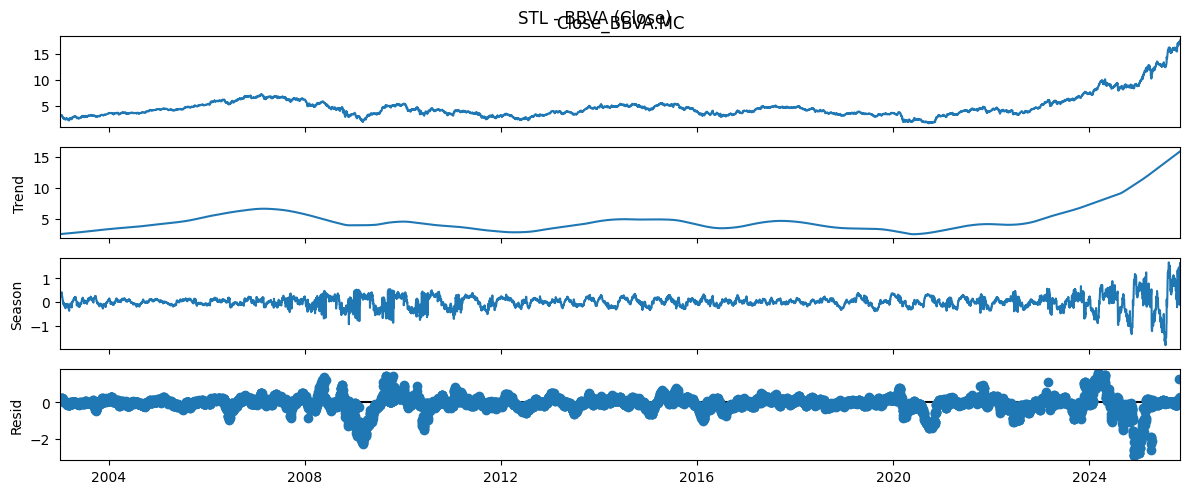

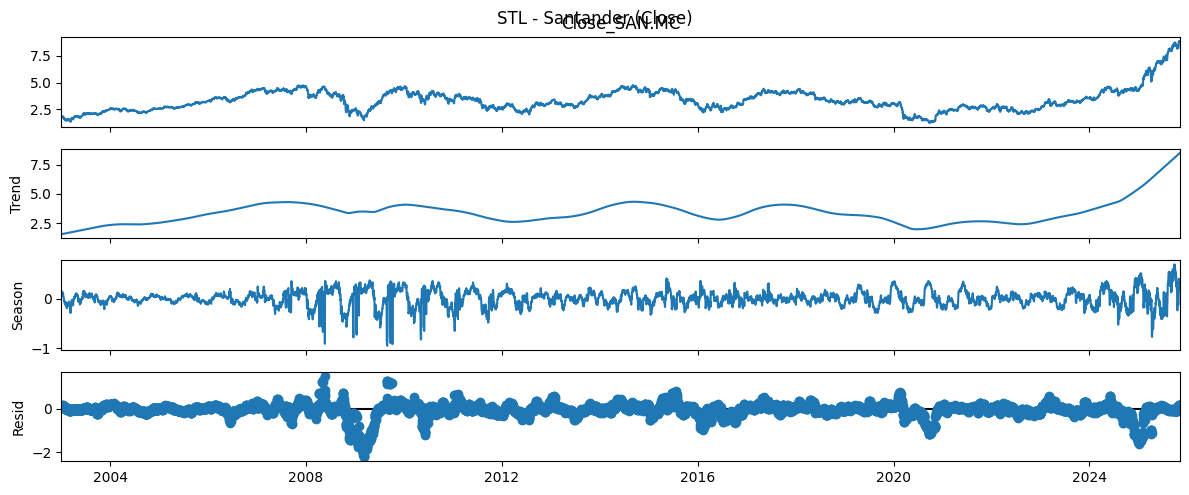

In [68]:
# STL BBVA
stl_bbva = STL(bbva['Close_BBVA.MC'].dropna(), period=252, robust=True).fit()
stl_bbva.plot()
plt.suptitle("STL - BBVA (Close)")
plt.show()

# STL Santander
stl_san = STL(san['Close_SAN.MC'].dropna(), period=252, robust=True).fit()
stl_san.plot()
plt.suptitle("STL - Santander (Close)")
plt.show()


#### Filtro HP (macro: Euribor/IPC/PIB/desempleo)
Explicación: HP separa tendencia larga y ciclo. Para series macro (mensuales o trimestrales) tendrás que ajustar lamb. Para datos diarios usareamos lamb=1600 como punto de partida pero para series macro con baja frecuencia considera lamb mayores (e.g., 129600 para series mensuales — ajusta según frecuencia).

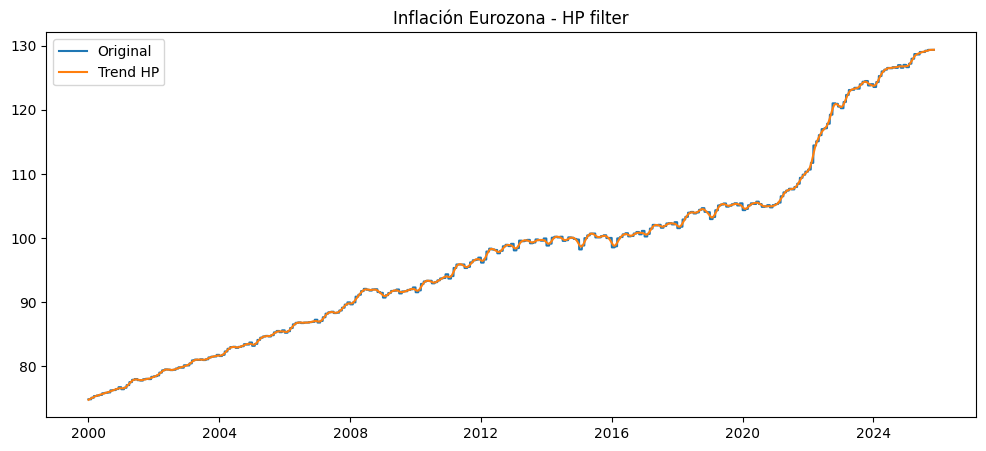

In [69]:
# Ejemplo con inflación Eurozona (si está en macro)
series = macro['inflacion_eurozona'].dropna()
if not series.empty:
    cycle, trend = hpfilter(series, lamb=129600)  # ejemplo para monthly-like series
    plt.figure()
    plt.plot(series.index, series, label='Original')
    plt.plot(trend.index, trend, label='Trend HP')
    plt.title("Inflación Eurozona - HP filter")
    plt.legend()
    plt.show()
else:
    print("No hay serie de 'inflacion_eurozona' en macro.")


Repite para desempleo_espana, Euribor, PIB (ajusta lamb según frecuencia).

#### 3. Detección de picos (VIX, IBEX, Brent, prima de riesgo) — rolling mean + z-score
Explicación: marcador robusto para identificar días de estrés: calculamos z-score usando rolling() y señalamos valores con |z| > umbral.


In [70]:
def detect_peaks_z(serie, window=60, threshold=2.0):
    rm = serie.rolling(window).mean()
    rs = serie.rolling(window).std()
    z = (serie - rm) / rs
    peaks = z.abs() > threshold
    return peaks, z

# Ejemplo VIX (si existe)
if 'VIX' in joint.columns:
    peaks_vix, z_vix = detect_peaks_z(joint['VIX'].dropna(), window=60, threshold=2.0)
    plt.plot(joint['VIX'], label='VIX')
    plt.scatter(joint['VIX'][peaks_vix].index, joint['VIX'][peaks_vix], color='red', label='Peaks')
    plt.title("Picos VIX (zscore rolling)")
    plt.legend()
    plt.show()
else:
    print("No hay VIX en joint.")


No hay VIX en joint.


Haz lo mismo para IBEX (si lo tienes), Brent (si lo tienes) y prima_de_riesgo (o proxy, e.g. spread bonos).

#### 4. Marcar fechas de picos comunes entre variables
Explicación: detectamos picos (boolean) para varias series, sumamos y tomamos fechas donde >= 2 o >=3 series coinciden — eso marca shocks sistémicos.

In [71]:
# Detectar picos para varias series (ajusta nombres según tu macro df)
candidates = {}
for col in ['VIX', 'IBEX_Close', 'Brent', 'prima_riesgo']:  # ajusta a tus columnas
    if col in joint.columns:
        p, _ = detect_peaks_z(joint[col].dropna(), window=60, threshold=2.0)
        candidates[col] = p

# Unir booleans por índice
peaks_df = pd.DataFrame(candidates).fillna(False)
if not peaks_df.empty:
    peaks_df['common_count'] = peaks_df.sum(axis=1)
    common_shocks = peaks_df[peaks_df['common_count'] >= 2]
    print("Fechas con picos simultáneos (>=2 series):")
    print(common_shocks.index.date[:50])
else:
    print("No se detectaron series para comparar picos.")


No se detectaron series para comparar picos.


#### 5.Correlaciones dinámicas.
Explicación: cómo cambian las correlaciones BBVA vs Santander, BBVA vs VIX, etc., a lo largo del tiempo.

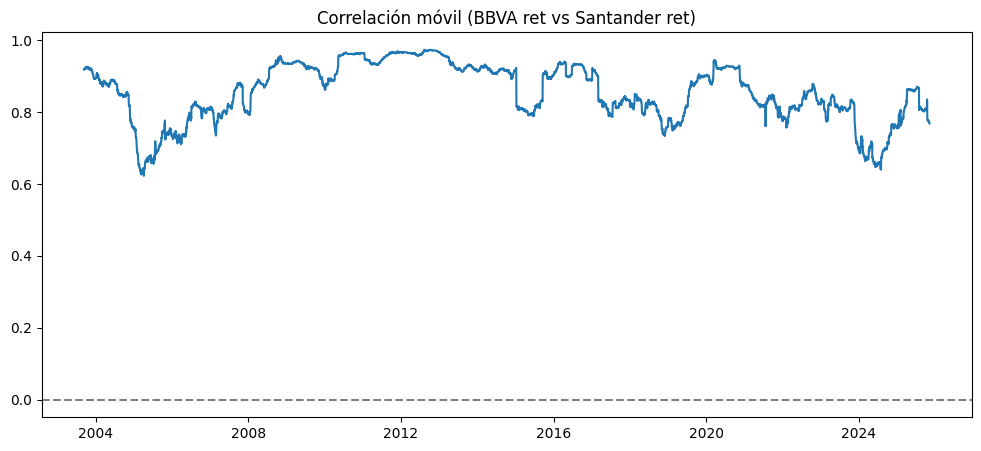

In [72]:
window = 252  # 1 año approx
# BBVA vs Santander closing prices log-returns
corr_bbva_san = bbva['ret'].rolling(window).corr(san['ret'])
plt.plot(corr_bbva_san)
plt.title("Correlación móvil (BBVA ret vs Santander ret)")
plt.axhline(0, linestyle='--', color='gray')
plt.show()

# BBVA vs VIX (ret vs level o ret vs ret)
if 'VIX' in joint.columns:
    corr_bbva_vix = bbva['ret'].rolling(window).corr(joint['VIX'])
    plt.plot(corr_bbva_vix)
    plt.title("Correlación móvil (BBVA ret vs VIX level)")
    plt.show()


ota: VIX es nivel y BBVA es retorno; puedes correlacionar ret con VIX o con ret(VIX) si lo prefieres.

#### 6. Volatilidad: rolling + GARCH
xplicación: estimamos volatilidad condicional con GARCH(1,1) y comparamos con volatilidad rolling.

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -15360.7
Distribution:                  Normal   AIC:                           30729.3
Method:            Maximum Likelihood   BIC:                           30757.4
                                        No. Observations:                 8346
Date:                Fri, Nov 07 2025   Df Residuals:                     8345
Time:                        15:47:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0508  1.533e-02      3.314  9.213e-04 [2.

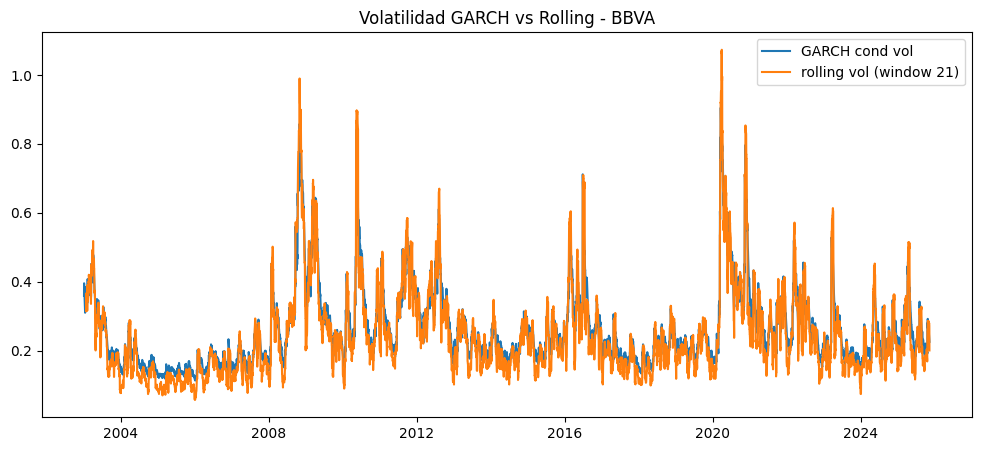

In [73]:
# Rolling vol ya calculada en preparación (vol_roll). Vamos a ajustar GARCH a los retornos de BBVA
bbva_rets = bbva['ret'].dropna()*100  # % returns

# Ajustar GARCH(1,1) (modela var cond)
am = arch_model(bbva_rets, vol='Garch', p=1, q=1, dist='normal')
res = am.fit(disp='off')
print(res.summary())

# Volatilidad condicional estimada (annualized)
cond_vol = res.conditional_volatility / 100 * np.sqrt(252)
plt.plot(cond_vol, label='GARCH cond vol')
plt.plot(bbva['vol_roll'], label='rolling vol (window {})'.format(window_vol))
plt.legend()
plt.title("Volatilidad GARCH vs Rolling - BBVA")
plt.show()


Repite para santander 


#### 7. Cointegración (BBVA vs Santander)
Explicación: testea si existe relación de largo plazo entre los precios (útil para pares trading).

In [74]:
# Usar precios (nivel); quitar NaNs
p1 = bbva['Close_BBVA.MC'].dropna()
p2 = san['Close_SAN.MC'].dropna()
# Alinear
dfp = pd.concat([p1, p2], axis=1).dropna()
score, pvalue, _ = coint(dfp.iloc[:,0], dfp.iloc[:,1])
print("Cointegration test p-value:", pvalue)
if pvalue < 0.05:
    print("Hay cointegración significativa (p < 0.05).")
else:
    print("No hay evidencia fuerte de cointegración.")


Cointegration test p-value: 0.86800864738767
No hay evidencia fuerte de cointegración.


#### 8.Cross-correlation lag analysis (¿un indicador anticipa a otro?)
Explicación: usar CCF o correlaciones con lags para ver si VIX anticipa movimientos en BBVA, etc.

In [75]:
from statsmodels.tsa.stattools import ccf

# Tomar series limpias y standardize
vix = joint['VIX'].dropna().loc[dfp.index.min():dfp.index.max()] if 'VIX' in joint.columns else None
bbva_ret = bbva['ret'].dropna().loc[dfp.index.min():dfp.index.max()]

if vix is not None:
    # Resample to align and dropna
    tmp = pd.concat([bbva_ret, vix], axis=1).dropna()
    x = (tmp['VIX'] - tmp['VIX'].mean())/tmp['VIX'].std()
    y = (tmp['ret'] - tmp['ret'].mean())/tmp['ret'].std()
    # ccf gives correlation at lags (positive lag => x leads y)
    lags = 30
    c = ccf(x, y)[:lags]
    plt.bar(range(len(c)), c)
    plt.axhline(0, color='k', linestyle='--')
    plt.title("CCF: VIX vs BBVA ret (pos lag => VIX leads BBVA)")
    plt.show()
else:
    print("No VIX para análisis de cross-corr.")


No VIX para análisis de cross-corr.


#### 9. Clusterización de periodos de crisis (PCA + KMeans)
Explicación: transformamos variables de estrés (VIX, vol rol, spreads, returns) a componentes y clusterizamos para identificar regimes (tranquilo vs estresado).

Cluster 0 - count: 1215
Cluster 1 - count: 940
Cluster 2 - count: 6171


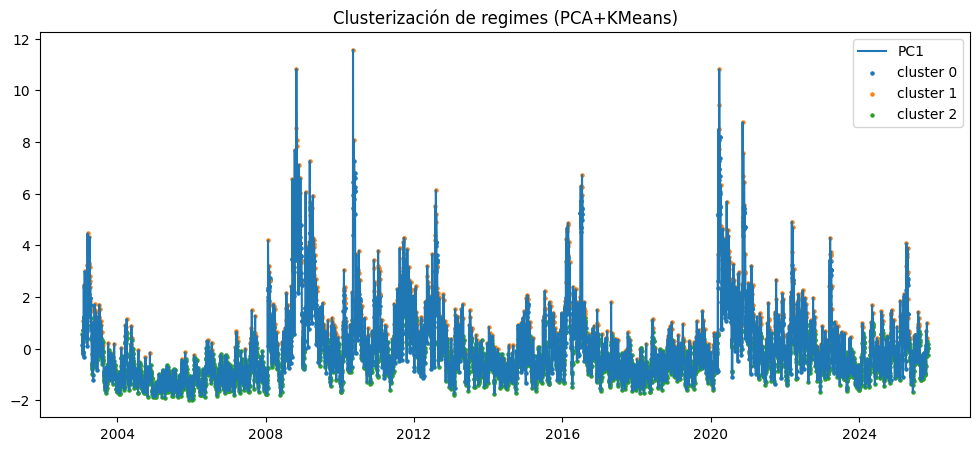

In [76]:
# Construir matrix de features por día (ajusta columnas)
features = pd.DataFrame({
    'BBVA_ret': bbva['ret'],
    'SAN_ret': san['ret'],
    'BBVA_vol': bbva['vol_roll'],
    'SAN_vol': san['vol_roll'],
})
# Añadir VIX y prima_riesgo si existen
for col in ['VIX','prima_riesgo','Brent']:
    if col in joint.columns:
        features[col] = joint[col]

features = features.dropna()

# Standardize
X = (features - features.mean()) / features.std()

# PCA para reducción
pca = PCA(n_components=3)
Z = pca.fit_transform(X)

# KMeans (2 or 3 clusters)
k = 3
km = KMeans(n_clusters=k, random_state=42).fit(Z)
labels = km.labels_

# Añadir etiquetas al df y ver periodos
features['cluster'] = labels
for i in range(k):
    print(f"Cluster {i} - count:", (features['cluster']==i).sum())

# Plot clusters on first PCA component timeline
plt.plot(pd.to_datetime(features.index), Z[:,0], label='PC1')
for i in range(k):
    idx = features.index[features['cluster']==i]
    plt.scatter(idx, Z[features['cluster']==i,0], s=5, label=f'cluster {i}')
plt.legend()
plt.title("Clusterización de regimes (PCA+KMeans)")
plt.show()


#### 10. Resumen de fechas críticas y salida para informe
Explicación: creamos una tabla con las fechas donde múltiples indicadores marcaron picos (vinculable a eventos históricos).

In [77]:
# Generar tabla de fechas críticas (union de picos de BBVA, SAN, VIX y prima)
peaks_list = {}
for name, ser in [('BBVA', bbva['ret']), ('SAN', san['ret']), ('VIX', joint.get('VIX'))]:
    if ser is not None:
        p, z = detect_peaks_z(ser.abs(), window=60, threshold=2.0)
        peaks_list[name] = p

peaks_tbl = pd.DataFrame(peaks_list).fillna(False)
peaks_tbl['count'] = peaks_tbl.sum(axis=1)
critical_dates = peaks_tbl[peaks_tbl['count'] >= 2].index
print("Fechas críticas detectadas (ejemplos):")
print(critical_dates.date[:50])

# Guardar CSV con las fechas y qué series hicieron pico
peaks_tbl.to_csv("peaks_by_series.csv")

Fechas críticas detectadas (ejemplos):
[datetime.date(2003, 3, 13) datetime.date(2003, 3, 14)
 datetime.date(2003, 5, 19) datetime.date(2003, 10, 3)
 datetime.date(2003, 11, 17) datetime.date(2003, 12, 1)
 datetime.date(2004, 1, 2) datetime.date(2004, 1, 29)
 datetime.date(2004, 2, 6) datetime.date(2004, 3, 11)
 datetime.date(2004, 3, 15) datetime.date(2004, 3, 17)
 datetime.date(2004, 5, 10) datetime.date(2004, 5, 19)
 datetime.date(2004, 7, 27) datetime.date(2004, 10, 1)
 datetime.date(2004, 10, 4) datetime.date(2004, 11, 17)
 datetime.date(2005, 3, 16) datetime.date(2005, 4, 15)
 datetime.date(2005, 7, 7) datetime.date(2005, 9, 26)
 datetime.date(2005, 9, 28) datetime.date(2005, 10, 31)
 datetime.date(2006, 1, 25) datetime.date(2006, 1, 26)
 datetime.date(2006, 2, 22) datetime.date(2006, 4, 21)
 datetime.date(2006, 5, 12) datetime.date(2006, 5, 17)
 datetime.date(2006, 5, 22) datetime.date(2006, 6, 8)
 datetime.date(2006, 10, 17) datetime.date(2006, 11, 24)
 datetime.date(2006, 11, 

#### Entrenamiento y modelado para BBVA 

Epoch 1/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.5635 - mae: 1.1224 - val_loss: 10.4408 - val_mae: 1.9882
Epoch 2/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3435 - mae: 0.4591 - val_loss: 8.3935 - val_mae: 1.6824
Epoch 3/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2956 - mae: 0.4203 - val_loss: 7.2837 - val_mae: 1.5577
Epoch 4/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2439 - mae: 0.3859 - val_loss: 6.4184 - val_mae: 1.4438
Epoch 5/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2313 - mae: 0.3690 - val_loss: 5.5033 - val_mae: 1.4020
Epoch 6/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2156 - mae: 0.3540 - val_loss: 4.8965 - val_mae: 1.1828
Epoch 7/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1791 - mae: 0.3252 - val_loss: 3.6619 - val_mae: 0.9637
Epoch 8/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1705 - mae: 0.3148 - val_loss: 3.3191 - val_mae: 1.0205
Epoch 9/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms

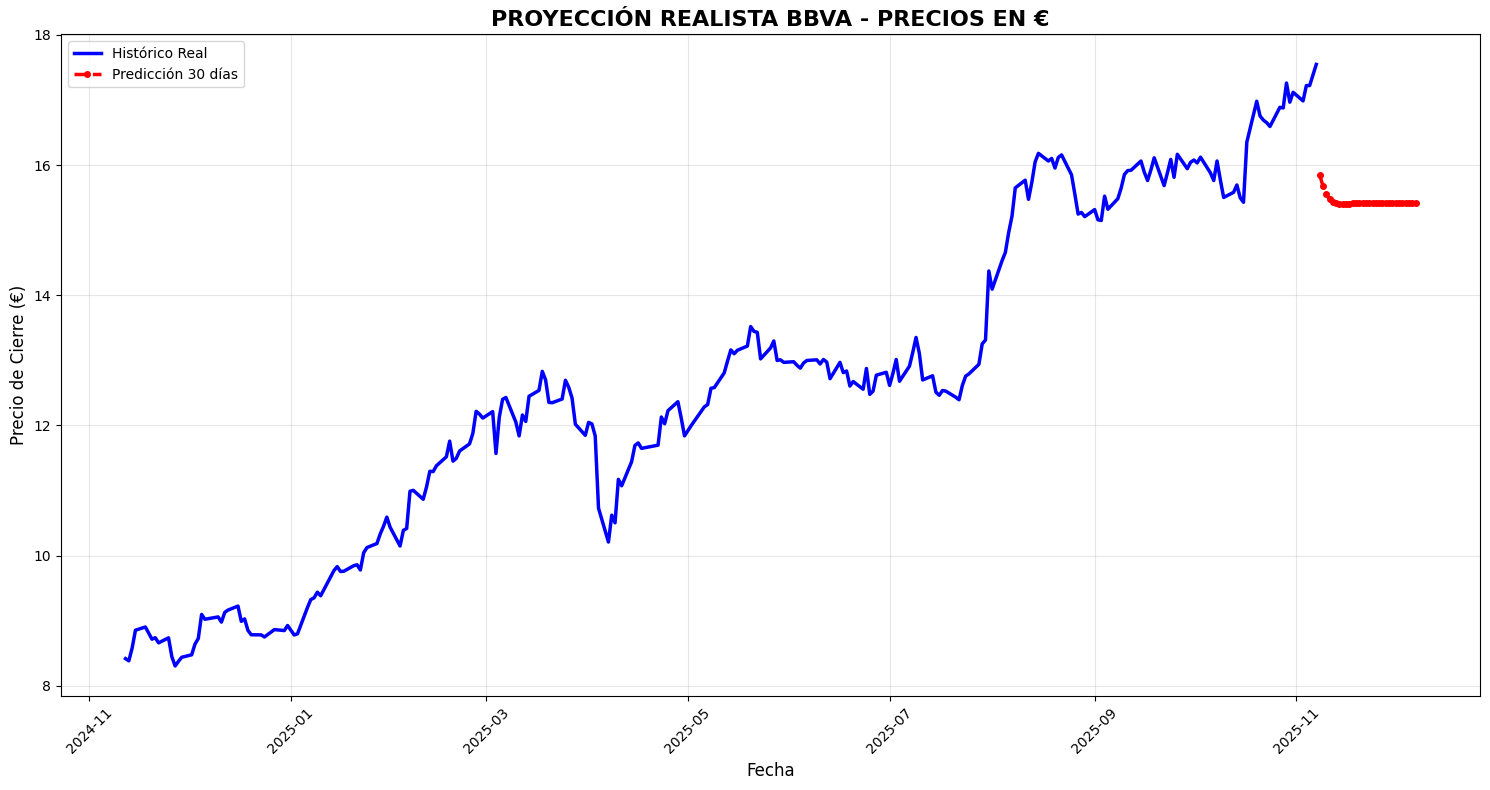

RESULTADOS REALISTAS:
Último precio real: 17.55€
Predicción Día 1: 15.85€
Predicción Día 30: 15.41€
Variación predicha: -2.8%


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. CARGAR Y PREPARAR DATOS CORRECTAMENTE
bbva = pd.read_csv("bbva_completo.csv", index_col=0, parse_dates=True)
df = bbva.copy()

# Usar SOLO las columnas realmente importantes
feature_cols = ['Close_BBVA.MC', 'Volume_BBVA.MC', 'High_BBVA.MC', 'Low_BBVA.MC', 'tasa_interes', 'inflacion']

# 2. CREAR SECUENCIAS
time_steps = 30  # Reducir para mejor generalización
X, y = [], []

for i in range(time_steps, len(df)):
    X.append(df[feature_cols].iloc[i-time_steps:i].values)
    y.append(df['Close_BBVA.MC'].iloc[i])  # Target: precio REAL

X, y = np.array(X), np.array(y)

# 3. ESCALAR CORRECTAMENTE
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, len(feature_cols))).reshape(X.shape)

# 4. MODELO MÁS SIMPLE Y ROBUSTO
model = Sequential([
    LSTM(32, input_shape=(time_steps, len(feature_cols))),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1)  # Precio real en €
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='mse', 
              metrics=['mae'])

# Entrenar con early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Dividir datos
split = int(0.8 * len(X))
X_train, X_val = X_scaled[:split], X_scaled[split:]
y_train, y_val = y[:split], y[split:]

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=16, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop],
                    verbose=1)

# 5. PREDECIR FUTURO REALISTA
def predecir_futuro_realista(dias=30):
    ultima_secuencia = X[-1]
    predicciones = []
    secuencia_actual = ultima_secuencia.copy()
    
    for i in range(dias):
        # Escalar
        sec_esc = scaler.transform(secuencia_actual.reshape(-1, len(feature_cols)))
        sec_esc = sec_esc.reshape(1, time_steps, len(feature_cols))
        
        # Predecir
        pred = model.predict(sec_esc, verbose=0)[0, 0]
        predicciones.append(pred)
        
        # Actualizar SOLO el precio, mantener otros features constantes
        nueva_fila = secuencia_actual[-1].copy()
        nueva_fila[0] = pred  # Actualizar solo el precio de cierre
        
        secuencia_actual = np.roll(secuencia_actual, -1, axis=0)
        secuencia_actual[-1] = nueva_fila
    
    return np.array(predicciones)

# 6. HACER PREDICCIÓN
predicciones = predecir_futuro_realista(30)

# 7. GRÁFICA REALISTA
plt.figure(figsize=(15, 8))

# Histórico (último año)
ultimo_año = df.index[-252:]  # 252 días hábiles ≈ 1 año
plt.plot(ultimo_año, df.loc[ultimo_año, 'Close_BBVA.MC'], 
         'b-', label='Histórico Real', linewidth=2.5)

# Predicciones futuras
fechas_futuro = [df.index[-1] + pd.Timedelta(days=i) for i in range(1, 31)]
plt.plot(fechas_futuro, predicciones, 
         'r--', label='Predicción 30 días', linewidth=2.5, marker='o', markersize=4)

plt.title('PROYECCIÓN REALISTA BBVA - PRECIOS EN €', fontsize=16, fontweight='bold')
plt.ylabel('Precio de Cierre (€)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# MOSTRAR RESULTADOS
print("="*60)
print("RESULTADOS REALISTAS:")
print("="*60)
print(f"Último precio real: {df['Close_BBVA.MC'].iloc[-1]:.2f}€")
print(f"Predicción Día 1: {predicciones[0]:.2f}€")
print(f"Predicción Día 30: {predicciones[-1]:.2f}€")
print(f"Variación predicha: {((predicciones[-1] - predicciones[0]) / predicciones[0] * 100):.1f}%")